In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

import os
from PIL import Image

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
train_dir = "/kaggle/input/pepfaces1000/pepfaces/train/"
val_dir = "/kaggle/input/pepfaces1000/pepfaces/val/"
batch_size = 16
image_height = 512
image_width = 512

In [3]:
class SegmentDataset(torch.utils.data.Dataset):
  def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
    """
      Инициализация датасета
    """
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.image_transform = image_transform
    self.mask_transform = mask_transform

    self.image_names = os.listdir(image_dir)

  def __len__(self):
    return len(self.image_names)

  def __getitem__(self, idx):
    """
      Возвращает пару изображение-маска по индексу
    """
    img_name = self.image_names[idx]
    img_path = os.path.join(self.image_dir, img_name)
    image = Image.open(img_path).convert("RGB")

    mask_name = os.path.splitext(img_name)[0] + "_mask.png"
    mask_path = os.path.join(self.mask_dir, mask_name)
    mask = Image.open(mask_path).convert("L")

    if self.image_transform and self.mask_transform:
      image = self.image_transform(image)
      mask = self.mask_transform(mask)

    return image, mask


In [4]:
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(std=[0.5, 0.5, 0.5], mean=[0.5, 0.5, 0.5])
])

mask_transform = transforms.Compose([
    transforms.ToTensor()
])

In [5]:
train_dataset = SegmentDataset(
    image_dir=train_dir + "images",
    mask_dir=train_dir + "masks",
    image_transform=image_transform,
    mask_transform=mask_transform
)

val_dataset = SegmentDataset(
    image_dir=val_dir + "images",
    mask_dir=val_dir + "masks",
    image_transform=image_transform,
    mask_transform=mask_transform
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

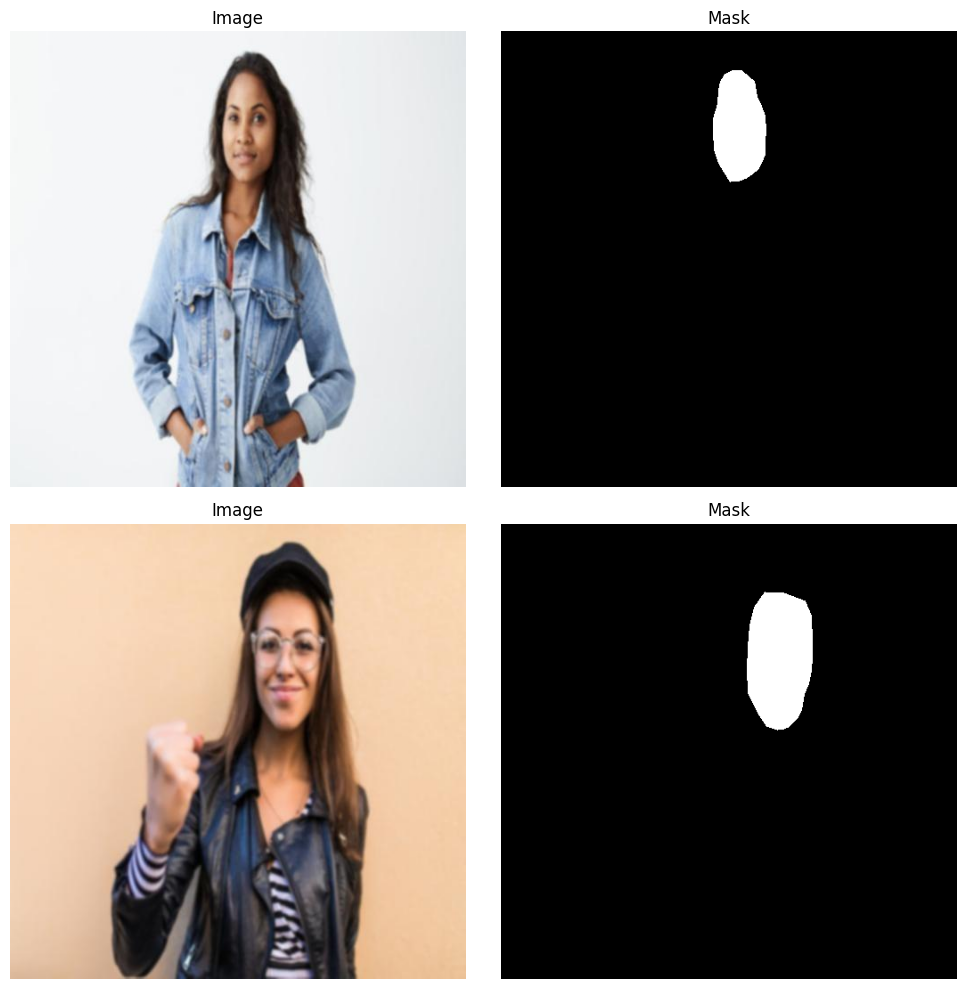

In [6]:
def denormalize(tensor, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def visualize_batch(images, masks):
    num_images = len(images[:2])
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))

    for i in range(num_images):
        axes[i, 0].imshow(denormalize(images[i]).permute(1, 2, 0))
        axes[i, 0].set_title("Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(masks[i].squeeze(), cmap="gray")
        axes[i, 1].set_title("Mask")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

for images, masks in train_loader:
    visualize_batch(images, masks)
    break

In [7]:
class unet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(unet, self).__init__()

        #encoder
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)

        self.bottleneck = self.conv_block(512, 1024)

        #decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(128, 64)

        #final_layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        """Создает блок свертки с relu и batch normalization"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, 2))
        enc3 = self.encoder3(F.max_pool2d(enc2, 2))
        enc4 = self.encoder4(F.max_pool2d(enc3, 2))

        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((enc3, dec3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((enc2, dec2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((enc1, dec1), dim=1)
        dec1 = self.decoder1(dec1)

        return self.final_conv(dec1)

In [40]:
model = unet()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

model.to(device)

Using 2 GPUs!


DataParallel(
  (module): unet(
    (encoder1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (encoder2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (encoder3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [43]:
def calculate_class_weights(train_loader):
    num_positive = 0
    num_negative = 0

    for images, masks in train_loader:
        num_positive += (masks == 1).sum().item()
        num_negative += (masks == 0).sum().item()

    weight_objects = num_negative / (num_positive + 1e-6)  
    return torch.tensor([weight_objects])

In [44]:
weights = calculate_class_weights(train_loader).to(device)
print(weights)

tensor([11.1641], device='cuda:0')


In [45]:
loss_func = nn.BCEWithLogitsLoss(pos_weight = weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [48]:
def recall_score(pred, target, threshold=0.5, epsilon=0.5):
    """
    Вычисляет recall (полноту) предсказаний для бинарной сегментации.
    """
    pred = (pred > threshold).float()
    tp = torch.sum((pred == 1) & (target == 1)).float()
    fn = torch.sum((pred == 0) & (target == 1)).float()

    recall = tp / (tp + fn + epsilon)

    return recall.item()

In [47]:
def vizualize_predict(image, pred, mask, threshold=0.5):
    """
    Визуализирует предсказания модели, реальную маску и само изображение
    """
    image = image.permute(1, 2, 0).cpu().numpy()
    pred = pred.squeeze().cpu().detach().numpy()
    mask = mask.squeeze().cpu().numpy()
    prediction_binary = (pred > threshold).astype(float)

    fig, axes = plt.subplots(1, 4, figsize=(10, 4))

    axes[0].imshow(image)
    axes[0].set_title("Исходное изображение")
    axes[0].axis("off")

    axes[1].imshow(mask, cmap="gray")
    axes[1].set_title("Реальная маска")
    axes[1].axis("off")

    axes[2].imshow(prediction_binary, cmap="gray")
    axes[2].set_title("Предсказание модели")
    axes[2].axis("off")

    overlay = image.copy()
    overlay[prediction_binary > 0] = [1, 0, 0]  # Красный цвет для объектов
    axes[3].imshow(overlay)
    axes[3].set_title("Наложение предсказания")
    axes[3].axis("off")

    plt.tight_layout()
    plt.show()
    

In [51]:
import time
def train_model(model, loss_func, optimizer, scheduler, device, num_epochs):
    since = time.time()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        model.train()
        running_loss = 0.0
        running_recall = 0.0    

        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            loss = loss_func(outputs, masks)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            running_recall += recall_score(outputs, masks)

        train_loss = running_loss / len(train_dataset)
        train_recall = running_recall / len(train_dataset)
        print(f"Train | loss: {train_loss:.4f}, recall: {train_recall:.4f}")
        
        model.eval()
        running_loss = 0.0
        running_recall = 0.0

        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                loss = loss_func(outputs, masks)

                running_loss += loss.item() * images.size(0)
                running_recall += recall_score(outputs, masks)

        for images, masks in val_loader:
            with torch.no_grad():
                pred = model(images[0].unsqueeze(0).to(device))
                vizualize_predict(images[0], pred, masks[0])
            break

        
        val_loss = running_loss / len(val_dataset)
        val_recall = running_recall / len(val_dataset)
        scheduler.step(val_loss)
        print(f"Val | loss: {val_loss:.4f}, recall: {val_recall:.4f}") 
        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    return model

In [49]:
for images, masks in train_loader:
    print("Images shape:", images.shape)  # Должно быть [batch_size, in_channels, height, width]
    print("Masks shape:", masks.shape)    # Должно быть [batch_size, height, width] или [batch_size, 1, height, width]
    break

Images shape: torch.Size([8, 3, 512, 512])
Masks shape: torch.Size([8, 1, 512, 512])


Epoch 1/15
----------
Train | loss: 0.2931, recall: 0.1159


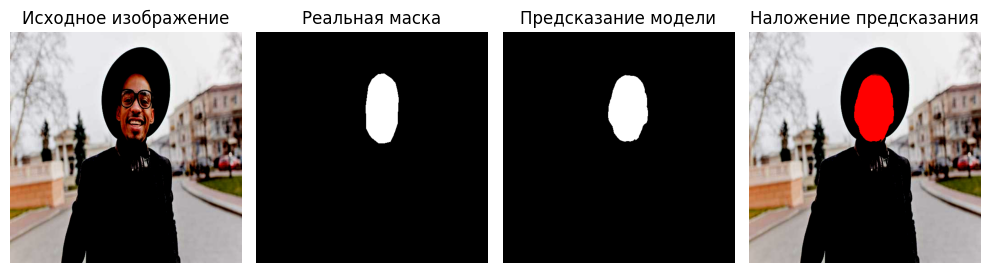

Val | loss: 0.3467, recall: 0.0998

Epoch 2/15
----------
Train | loss: 0.2295, recall: 0.1177


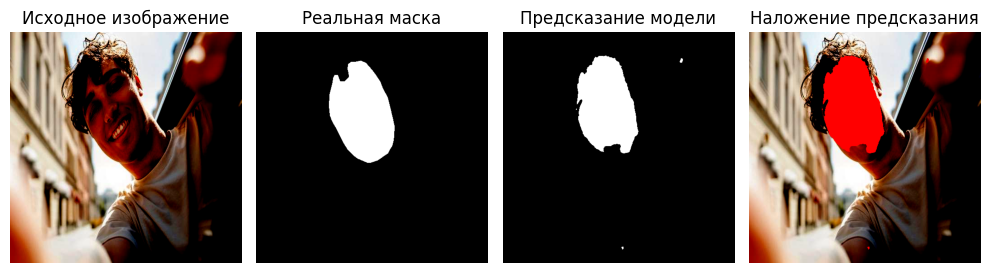

Val | loss: 0.1629, recall: 0.1206

Epoch 3/15
----------
Train | loss: 0.1701, recall: 0.1198


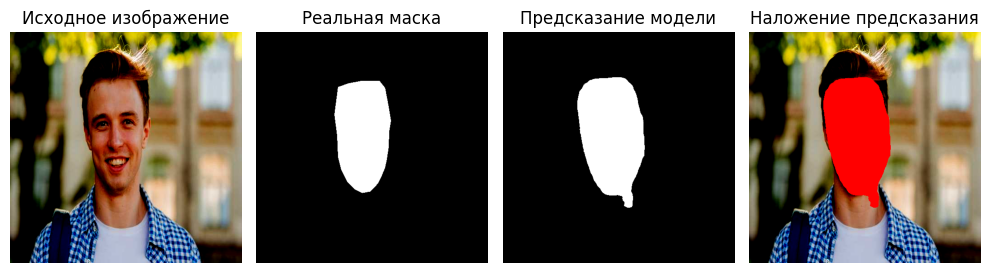

Val | loss: 0.2200, recall: 0.1233

Epoch 4/15
----------
Train | loss: 0.1363, recall: 0.1210


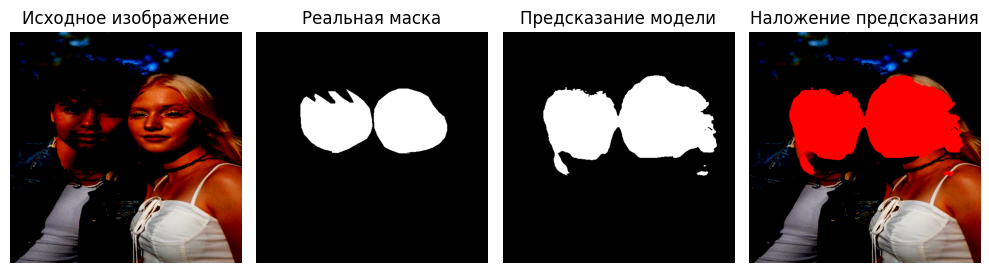

Val | loss: 0.1006, recall: 0.1231

Epoch 5/15
----------
Train | loss: 0.1222, recall: 0.1215


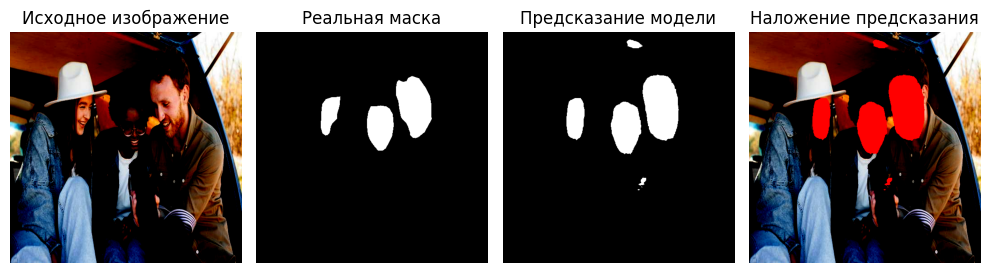

Val | loss: 0.0960, recall: 0.1232

Epoch 6/15
----------
Train | loss: 0.0812, recall: 0.1229


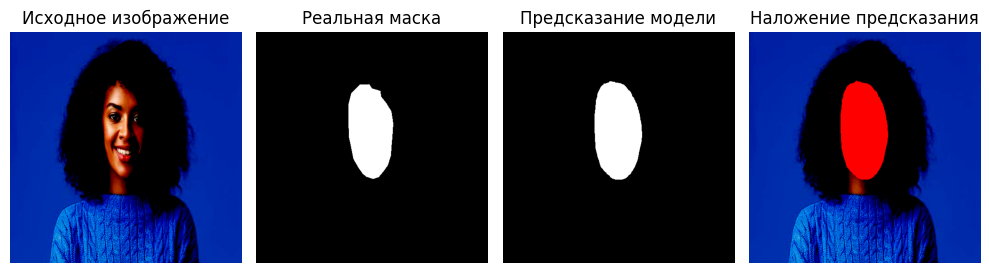

Val | loss: 0.2475, recall: 0.1244

Epoch 7/15
----------
Train | loss: 0.0665, recall: 0.1234


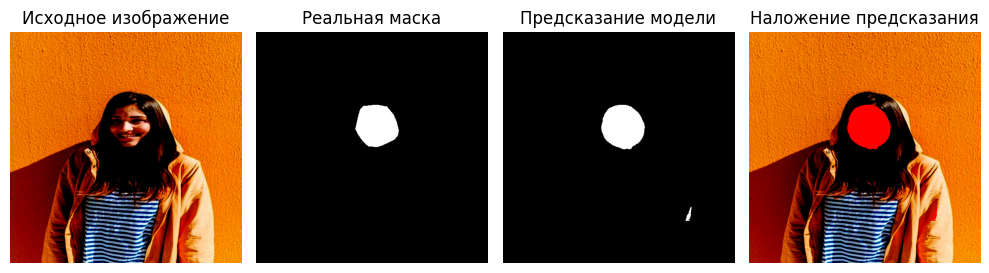

Val | loss: 0.0781, recall: 0.1226

Epoch 8/15
----------
Train | loss: 0.0549, recall: 0.1237


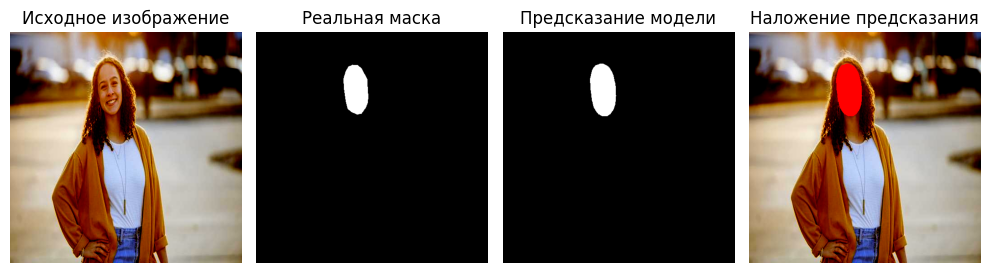

Val | loss: 0.0893, recall: 0.1215

Epoch 9/15
----------
Train | loss: 0.0513, recall: 0.1238


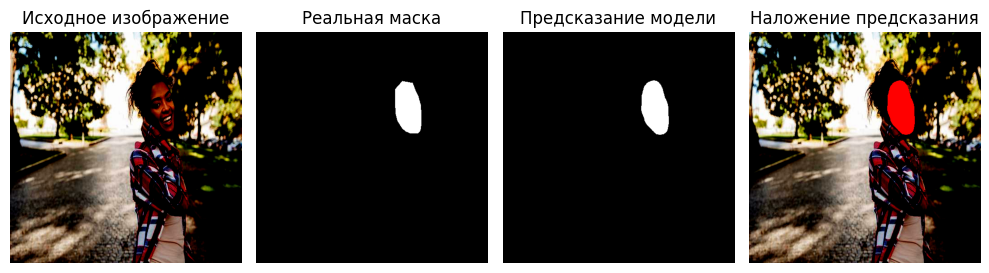

Val | loss: 0.0691, recall: 0.1223

Epoch 10/15
----------
Train | loss: 0.0472, recall: 0.1240


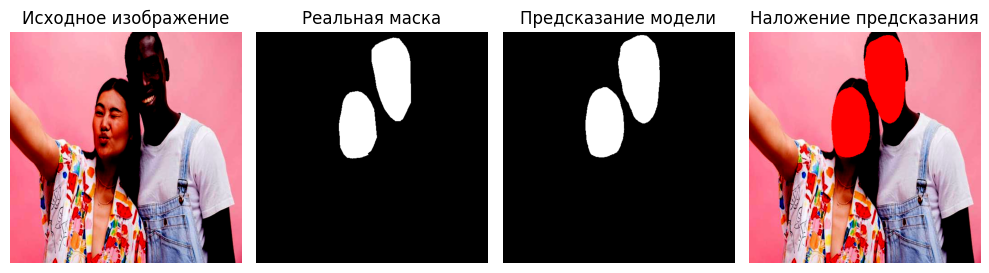

Val | loss: 0.0755, recall: 0.1220

Epoch 11/15
----------
Train | loss: 0.0407, recall: 0.1241


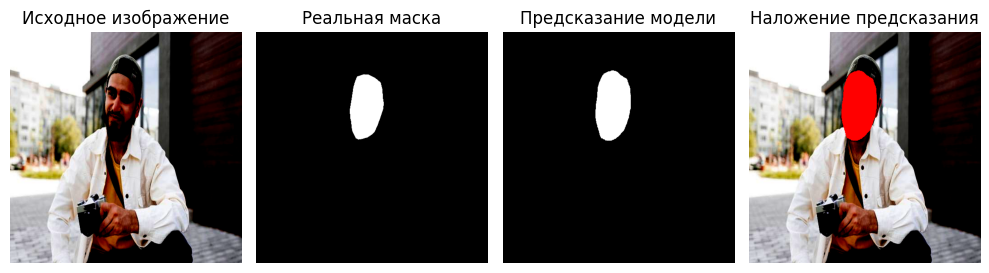

Val | loss: 0.1339, recall: 0.1202

Epoch 12/15
----------
Train | loss: 0.0632, recall: 0.1234


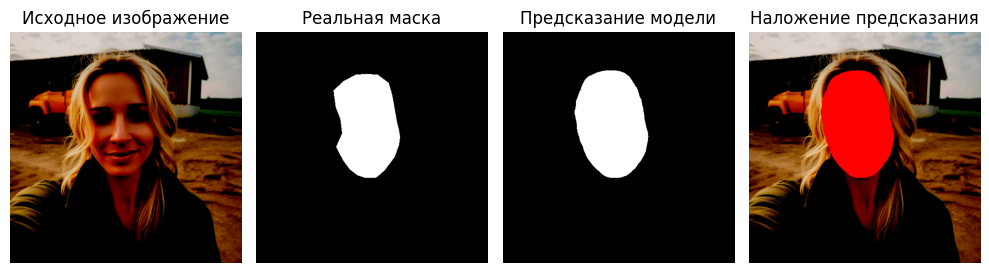

Val | loss: 0.0608, recall: 0.1231

Epoch 13/15
----------
Train | loss: 0.0372, recall: 0.1242


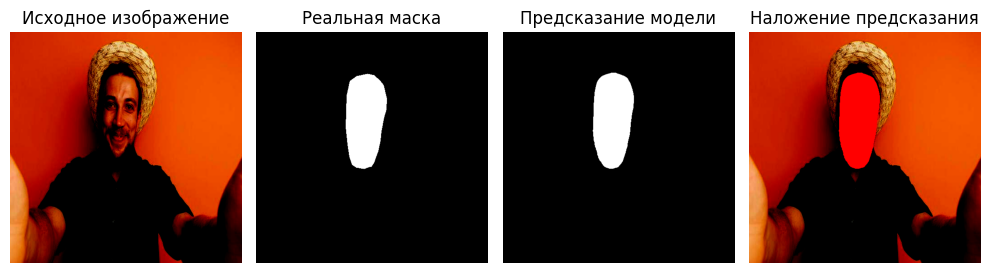

Val | loss: 0.0671, recall: 0.1228

Epoch 14/15
----------
Train | loss: 0.0323, recall: 0.1244


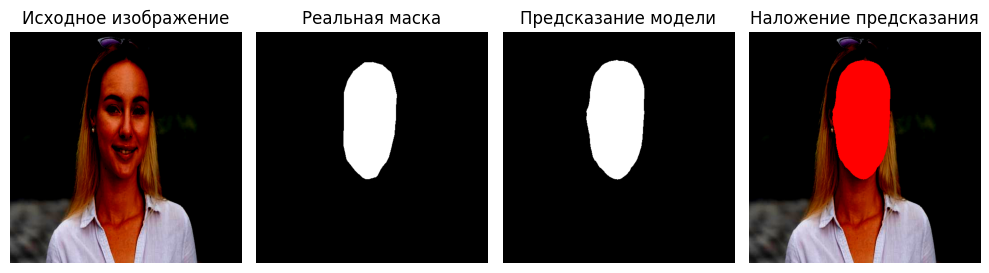

Val | loss: 0.0888, recall: 0.1224

Epoch 15/15
----------
Train | loss: 0.0424, recall: 0.1240


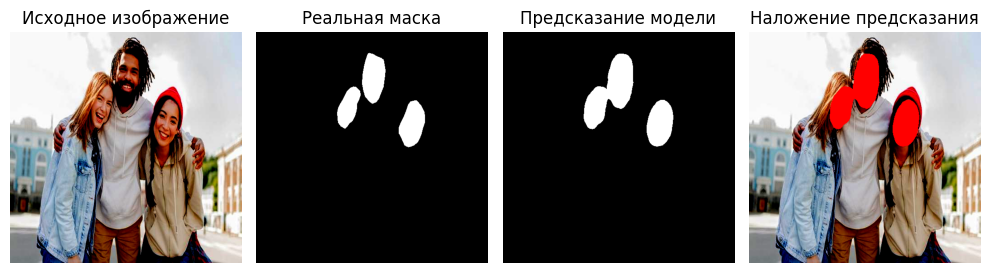

Val | loss: 0.0915, recall: 0.1209

Training complete in 131m 43s


In [52]:
num_epochs = 15
model = train_model(model, loss_func, optimizer, scheduler, device, num_epochs)

In [56]:
torch.save(model.state_dict(), "model_weights.pth")

In [58]:
torch.save(model.state_dict(), '/kaggle/working/model_weights.pth')